# Apply Neural Networks to the Stock Market

Notebook to explore limited set of NY stock exchange data over around 40 years, as part of the Portland Data Science group (Mar 2018).
Data selected by Matt Borthwick from Yahoo! Finance.
Working with Neural Network group: Matt, John Burt, Manny, Isil, Kenny, Jhoan, Mark C.

Our goal is to predict weekly returns on 6 industry based ETFs, as well
as aggregate market performance (such as Russel3000).  We will also
be using some macroeconomic indicators as well.
This notebook currently loads the data, transforms it, and applies a
simple neural network to try predicting the next days stock prices.
The first model was built in tensorflow (and is currently broken).  THere is a second network written in Keras.

The plan is to train on this data (up to Sep 2017),
validate on (Oct-Dec 2017), and test in final session on (Jan-Mar 2018).

(For more exploratory screwing around, and other attempts at time-series see PDX_finance1)

Currently Contains:
-Colab setup
-Loading data
-Tensorflow RNN (currently borked at prediction stage - wrong size? No idea what changed)
-Keras RNN  (not working yet)
-Keras Deep network

# Google Colab setup

First up however, we need to install modules to load up our google drive for storage.  (Code taken from this helpful post https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)
(Code and commands didn't look sketchy/malicious, but I didn't examine the PPA too closely either.)

This code is for execution inside a Jupyter notebook on colab.google.com.
It gives Colab access to your Google Drive in order to load/save data from within the notebook.
Colab has most popular libraries (numpy, pandas, tensorflow, matplotlib).  I'm not sure how extensive it is.

I've found opening a jupyter notebook on google drive automatically opens the Colab.

In [ ]:
#Install modules on local machine.
!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
!add-apt-repository -y ppa:alessandro-strada/ppa 2>&1 > /dev/null
!apt-get update -qq 2>&1 > /dev/null
!echo 'past update'
!apt-get -y install -qq google-drive-ocamlfuse fuse
!echo 'installed fuse'

In [ ]:
from google.colab import auth
auth.authenticate_user()
from oauth2client.client import GoogleCredentials
creds = GoogleCredentials.get_application_default()
import getpass
!google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret} < /dev/null 2>&1 | grep URL
print('past first command')
vcode = getpass.getpass()
!echo {vcode} | google-drive-ocamlfuse -headless -id={creds.client_id} -secret={creds.client_secret}

In [ ]:
#Mounts google drive, and changes to that directory
!mkdir -p drive 
!google-drive-ocamlfuse drive

import os
os.chdir("drive")

#Should now be in the root of your google-drive, and now free to load/save existing files.

# Load Libraries and Data

Now to load libraries, and data for all stocks, ETFs, and indicators.
All of those will get stuck together into one total dataframe.
(This is where I start my analysis on my home machine.)

In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import re

%matplotlib inline
# automatically reload files.
%load_ext autoreload
%autoreload 2

In [2]:
def load_stock_data():

    #Data compiled from Yahoo! Finance data by Matt Borthwick
    df_close=pd.read_csv('data/stocks-us-adjClose.csv',index_col=0,parse_dates=True)
    df_open=pd.read_csv('data/stocks-us-adjOpen.csv',index_col=0,parse_dates=True)
    df_high=pd.read_csv('data/stocks-us-adjHigh.csv',index_col=0,parse_dates=True)
    df_low=pd.read_csv('data/stocks-us-adjLow.csv',index_col=0,parse_dates=True)
    df_vol=pd.read_csv('data/stocks-us-Volume.csv',index_col=0,parse_dates=True)
    df_close.index.name='date'
    df_open.index.name='date'
    df_high.index.name='date'
    df_low.index.name='date'
    df_vol.index.name='date'

    #Follow Leffers and rename columns.
    df_close_new=[];
    df_open_new=[];
    df_low_new=[];
    df_high_new=[];
    df_vol_new=[];

    for name in df_close.columns:
        df_close_new.append(name+'close')

    for name in df_open.columns:
        df_open_new.append(name+'open')

    for name in df_low.columns:
        df_low_new.append(name+'low')

    for name in df_high.columns:
        df_high_new.append(name+'high')

    for name in df_vol.columns:
        df_vol_new.append(name+'vol')

    df_close.columns=df_close_new
    df_open.columns=df_open_new
    df_low.columns=df_low_new
    df_high.columns=df_high_new
    df_vol.columns=df_vol_new

    #join all stocks together.
    df_stock=df_close.join(df_open,how='inner')
    df_stock=df_stock.join(df_high,how='inner')
    df_stock=df_stock.join(df_low,how='inner')
    df_stock=df_stock.join(df_vol,how='inner')

    return df_stock


In [4]:
def load_etfs():
    """load_etfs
    Create combined ETF/RUA data.
    Uses initial training data data up to Sep 2017.
    Augmented to also load up data from Sep-Dec 2017.
    """
    # df_etf = pd.read_csv('data/sector_ETFs.csv',index_col=0,parse_dates=True)
    # #latest ETFs include ^RUA.
    # df_etf2 = pd.read_csv('data/sector_etfs-2-corrected.csv',index_col=0,parse_dates=True)
    # df_etf=df_etf.append(df_etf2)
    # df_rua=pd.read_csv('data/market.csv',index_col=0,parse_dates=True)
    # df_rua.columns=['Market (^RUA)']
    # df_etf.update(df_rua,overwrite=True)

    df_etf=pd.read_csv('data/sector_etfs3.csv',index_col=0,parse_dates=True)

    return df_etf

def clean_new_etfs(etf_cols):
    """clean_new_etfs
    Loads up ETF/RUA from Sep2017 to Apr 2018.
    Fills in missing NA via first replacing with median, then taking 
    average of neighbouring points.
    Note: Off by 1% from earlier values.  
    """
    df_tot=pd.DataFrame()
    for etf_name in etf_cols:
        #match via regex
        mc=re.search('\(([A-Z\^]+)\)',etf_name)
        #retrieve the match
        etf_ticker=mc.group(1)      
        df=pd.read_csv('data/latest_etf/'+etf_ticker+'.csv', index_col=0,parse_dates=True,na_values='null')
        df.rename(columns={'Adj Close':etf_name},inplace=True)
        #only join based on adjusted close

        #Kill missing values via linear interpolation.
        ser=df.iloc[:,4].copy()
        msk=np.isnan(ser.values)
        ind=np.arange(len(ser))[msk]
        #replace multiple NA with median.
        ser[msk]=ser.median()
        #for isolated values, replace by the average on either side.    
        for i in ind:
            ser.iloc[i]=(ser.iloc[i-1]+ser.iloc[i+1])/2
        ser.reindex(df.index )
        df_tot=df_tot.join(ser,how='outer')
    return df_tot    
    
def load_indicators(tag='Train'):
    """load_indicators
    Based on Matt Leffers code for reading in indicators.
    Adjusted to also use a tag for train/test.  
    """
    
    # remove warnings
    import csv
    import warnings

    ##Pieter Leffer's code for reading in indicators
    warnings.filterwarnings('ignore')

    # Leffers ran into errors importing the file because of non-ascii characters in the heading
    #Here is a piece of code Leffers got from stack overflow to fix that problem.
    df_ind=[]
    with open('data/Indicators_'+tag+'.csv', newline='', encoding='utf-8', errors='ignore') as f:
        reader = csv.reader(f)
        for row in reader:
            df_ind.append(row)

    df_ind=pd.DataFrame(df_ind)
    df_ind.columns=df_ind.iloc[0]
    Column_Reference=df_ind.iloc[1].copy()
    print(df_ind.columns)
    #Drop useless rows (last row is empty)
    df_ind.drop([0,1],axis=0,inplace=True)

    # #Change the formatting of the variables. Datetime to the ones for dates, integers for the ones that aren't
    for i in range(0,len(df_ind.columns)):
        col_name=df_ind.columns[i]
        if re.search('_dt',col_name):
            df_ind[col_name] = pd.to_datetime(df_ind[col_name],  format = '%m/%d/%Y',  errors='coerce')
            #print(col_name,'time')
        else:
            df_ind[col_name] = pd.to_numeric(df_ind[col_name], errors='ignore')
            #print(col_name,'val')

    # #Reset the index because we dropped rows in the DataFrame, Using the drop command to remove the old index
    df_ind.reset_index(drop=True, inplace=True)

    # #make a time index too.
    df_ind.index=pd.DatetimeIndex(df_ind['date'])

    # #drop all NaTs
    msk=np.isnat(df_ind.index)
    df_ind=df_ind[~msk]
    df_ind.drop(df_ind.columns[[0,1]],axis=1,inplace=True)
    return df_ind

In [5]:
df_etf=load_etfs()

In [14]:
df_etf['2018'].plot()
plt.show()

In [264]:
etf_cols=['Technology (IYW)', 'Basic Materials (IYM)', 'Consumer Goods (IYK)',
       'Services (IYC)', 'Healthcare (IYH)', 'Utilities (IDU)',
       'Market (^RUA)']

In [6]:
ind_col=df_ind.columns

for col_name in ind_col:
    if re.search('_dt',col_name):
       print(col_name)

NameError: name 'df_ind' is not defined

In [18]:
#loads stock data up to Sep 2017.
df_stocks=load_stock_data()

In [20]:
#load ETFs/RUA up to Apr2018
df_target=load_etfs()

In [15]:
#load all indicators up to Apr2018
df_ind_train=load_indicators(tag='Train')
df_ind_test=load_indicators(tag='Test')

Index(['', 'date', 'HOUST', 'HOUST_dt', 'UNRATENSA', 'UNRATENSA_dt', 'EMRATIO',
       'EMRATIO_dt', 'UEMPMED', 'UEMPMED_dt', 'UMCSENT', 'UMCSENT_dt',
       'USSLIND', 'USSLIND_dt', 'KCFSI', 'KCFSI_dt', 'IPMAN', 'IPMAN_dt',
       'VIXCLS', 'VIXCLS_dt', 'DGS10', 'DGS10_dt'],
      dtype='object', name=0)


Index(['', 'date', 'HOUST', 'HOUST_dt', 'UNRATENSA', 'UNRATENSA_dt', 'EMRATIO',
       'EMRATIO_dt', 'UEMPMED', 'UEMPMED_dt', 'UMCSENT', 'UMCSENT_dt',
       'USSLIND', 'USSLIND_dt', 'KCFSI', 'KCFSI_dt', 'IPMAN', 'IPMAN_dt',
       'VIXCLS', 'VIXCLS_dt', 'DGS10', 'DGS10_dt'],
      dtype='object', name=0)


In [16]:
df_ind=df_ind_train.append(df_ind_test)
#drop duplicate rows/days
drop_msk=df_ind.index.duplicated() #|(df_ind.index.dayofweek>=5)  
df_ind.drop(df_ind.index[drop_msk],inplace=True)

#append indicators to end of dataframe.
drop_col_num=df_ind.columns.str.contains('[date]|[_dt]')
keep_col    =df_ind.columns[~drop_col_num]
print(keep_col)

Index(['HOUST', 'UNRATENSA', 'EMRATIO', 'UEMPMED', 'UMCSENT', 'USSLIND',
       'KCFSI', 'IPMAN', 'VIXCLS', 'DGS10'],
      dtype='object', name=0)


In [414]:
df_ind.shape

(17347, 20)

In [21]:
#join all stocks together.
df_tot=df_target.join(df_ind.loc[:,keep_col],how='left')
df_tot=df_tot.join(df_stocks,how='left')

#drop weekends.
# msk=df_tot.index.dayofweek>=5
# df_tot.drop(df_tot.index[msk],inplace=True)

In [23]:
df_tot.tail()

            Technology (IYW)  Basic Materials (IYM)  Consumer Goods (IYK)  \
Date                                                                        
2018-04-02        164.263974              94.309595            116.571445   
2018-04-03        165.967538              95.603845            118.541439   
2018-04-04        168.512877              96.075393            120.692352   
2018-04-05        168.933756              98.332804            121.566783   
2018-04-06        164.915347              96.045296            119.938527   

            Services (IYC)  Healthcare (IYH)  Utilities (IDU)  Market (^RUA)  \
Date                                                                           
2018-04-02      177.337173        168.670835       127.237740    1530.280029   
2018-04-03      179.281295        171.458616       127.832407    1549.329956   
2018-04-04      182.167438        173.865343       128.064221    1566.950000   
2018-04-05      184.311998        173.845283       129.13259

In [24]:
#keep numbers of Stocks, ETFS, indicators.
Nstocks_tot=int(df_stocks.shape[1]/5)
Netf=7
Nind=10

In [25]:
#make vectors of indices in total to extract together.
ind_ind=np.arange(Netf,Netf+Nind)
etf_ind=np.arange(0,Netf)
Npre=Netf+Nind
close_ind=Npre+np.arange(0,Nstocks_tot)
open_ind=Npre+np.arange(Nstocks_tot,2*Nstocks_tot)
high_ind=Npre+np.arange(2*Nstocks_tot,3*Nstocks_tot)
low_ind=Npre+np.arange(3*Nstocks_tot,4*Nstocks_tot)
vol_ind=Npre+np.arange(4*Nstocks_tot,5*Nstocks_tot)

#make global array of indices to take logs/differences of
#take differences for stock prices and ETF data
diff_ind = np.append(etf_ind,Npre+np.arange(4*Nstocks_tot))
#take logs for stock prices, volumes and ETFs.
log_ind = np.append(etf_ind,Npre+np.arange(5*Nstocks_tot))

In [348]:
%pdb off

Automatic pdb calling has been turned OFF


In [26]:
df_tot.tail(n=10)

            Technology (IYW)  Basic Materials (IYM)  Consumer Goods (IYK)  \
Date                                                                        
2018-03-23        166.027662              94.901534            116.008584   
2018-03-26        172.811872              96.687404            117.857971   
2018-03-27        166.618911              95.694137            117.435823   
2018-03-28        164.955425              94.480153            118.189648   
2018-03-29        168.562985              96.396447            119.516387   
2018-04-02        164.263974              94.309595            116.571445   
2018-04-03        165.967538              95.603845            118.541439   
2018-04-04        168.512877              96.075393            120.692352   
2018-04-05        168.933756              98.332804            121.566783   
2018-04-06        164.915347              96.045296            119.938527   

            Services (IYC)  Healthcare (IYH)  Utilities (IDU)  Market (^RUA

In [105]:
#Old version
# df_tot=df_stocks.join(df_ind.loc[df_stocks.index,keep_col],how='left')
# df_tot=df_tot.join(df_target,how='outer')

In [223]:
import pickle
#dump dataframe as pickle object for ease.
file_name='data/df_tot_train.pickle'
fileObj=open(file_name,'wb')
pickle.dump(df_tot,fileObj)
fileObj.close()

Looking at the number of NA values (summed across columns) suggests that
there are missing values in these stocks.

Could set all NA to zero, then apply linear interpolation to handle isolated missing days.  Let's check the pattern of missing days.

In [9]:
#Plot pattern of NA values.  Weird stripes?
plt.figure(figsize=(10,6))
col=df_close.columns[0:]
plt.imshow(np.isnan(df_vol.loc['2000':,col]),aspect='auto')
plt.show()

# Data Transformation

For the initial testing, I'm just building a model based on the 100 oldest stocks (or whichever come first), and looking at 2002-2006.
Why then?  Because it looks relatively well behaved.
The model is trained on the first half of the data, and we then run the
network on the whole data set.

I'm currently just taking the base-10 log of the data, and scaling each
stock to lie with [-1,1].  I found differencing the data lead to
pretty crappy results (then again, these are also pretty crap results).

So there's some choices to be played with here:
- scaling: variance vs max/min
- differencing?

In [276]:
def take_log10(X,log_ind):
    """take_log10(X)
    Takes base10-log of X.  Sets NaN to zero, and shifts zero values by 1E-16.
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    y=X.copy()
    y[np.isnan(y)]=0    
    #take logs. (shift zero to avoid NANs)
    y[:,log_ind] = np.log10(y[:,log_ind]+1E-16)
    return y

def scale_maxmin(X,log_ind):
    """scale_maxmin

    Scales each price column by taking log, and max/min scaling.
    Takes log of open/high/low/volumes/etf.
    Does not take log of indicators.
    Max-min scales all of them.
    """
    y=take_log10(X,log_ind)
    y_max = np.nanmax(y,axis=0)
    y_min = np.nanmin(y,axis=0)
    #compute middle and differences of the max/min.
    avg = 0.5*(y_max+y_min)
    rng = 0.5*(y_max-y_min)
    #scale to [-1,+1]
    yscaled= (y-avg)/rng
    return yscaled,rng,avg

def rescale_maxmin_log(Xscaled,avg,rng,log_ind):
    """rescale_maxmin

    Undoes log-max/min scaling. 
    First undoes max/min scaling.  
    Then exponentiates all variables which had log taken.

    Input: Xscaled (nrow, ncol) np.array of scaled values
           avg (ncol) np.array of average/mean values to shift by
           rng (ncol) np.array of standard devations to scale by
           
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X= avg + rng*Xscaled
    #take logs. (shift zero to avoid NANs)
    X[:,log_ind] = 10**X[:,log_ind]
    return X

def scale_diff_var(X,log_ind,diff_ind):
    """scale_diff_var
    Scales each column by taking log, then differencing.
    Then scales to have zero mean, and unit standard deviation..
    Takes log of all data.
    """
    y=take_log10(X,log_ind)
    #take differences logs. (shift zero to avoid NANs)    
    y[:,diff_ind] = np.diff(y[:,diff_ind],axis=0)
    y_std = np.nanstd(y,axis=0)
    y_mean = np.nanmean(y,axis=0)
    yscaled= (y-y_mean)/y_std
    return yscaled,y_mean,y_std

def scale_diff_iqr(X,diff_ind,log_ind):
    """scale_diff_var
    Scales each column by taking log, then differencing.
    Then scales to have zero median, and so 95% inter-quartile range is unity.
    Should handle the long-tail distributions we will encounter
    with some grace.  
    Only take the log for the stock/etf data.
    """

    y=take_log10(X,log_ind)
    #take differences logs. (shift zero to avoid NANs)
    nrow,ncol=y.shape
    y2=np.zeros((nrow-1,ncol))
    y2[:,diff_ind] = np.diff(y[:,diff_ind],axis=0)
    y2[:,~diff_ind] = y[1:,~diff_ind]

    keep_msk=(y2==y2)
    # print(keep_msk.shape,y2[keep_msk].shape)
    X_025 = np.nanpercentile(y2,q=2.5,axis=0)
    X_975 = np.nanpercentile(y2,q=97.5,axis=0)
    X_range = X_975-X_025
    print(X_range[:5])
    X_median = np.nanmedian(y2,axis=0)
    print(X_median[:5])
    Xscaled=np.where(keep_msk, (y2-X_median)/X_range,0)
    return Xscaled,X_median,X_range

def rescale_diff_iqr(Xscaled,mu,sd,x0,log_ind,diff_ind):
    """rescale_diffvar

    Undoes log-max/min scaling. 
    Takes log of open/high/low/volumes/etf.
    Does not take log of indicators.
    Max-min scales all of them.
    Only take the log for the stock/etf data.
    """
    #set missing values to zero.  (to avoid issues in network with NaNs)
    X= mu + sd*Xscaled
    X= np.insert(X,0,x0,axis=0)
    X[:,diff_ind] = np.cumsum(X[:,diff_ind],axis=0)
    #take logs. (shift zero to avoid NANs)
    X[:,log_ind] = 10**X[:,log_ind]
    return X

In [335]:
%pdb on 

Automatic pdb calling has been turned ON


In [165]:
np.diff(np.arange(9).reshape(3,3),axis=0)

array([[3, 3, 3],
       [3, 3, 3]])

In [277]:
Xsub=df_tot['2001':'2004'].values
tsub=df_tot['2001':'2004'].index
Xsub_scale,Xsub_rng, Xsub_avg=scale_diff_iqr(Xsub,diff_ind,log_ind)


[ 0.00044721  0.00040349  0.00030301  0.00029244  0.00027142]


[ 0.03118747  0.03034051  0.01700173  0.02318996  0.01905181]


In [278]:
np.isnan(Xsub_scale[:,8]).sum()

3520

In [275]:
Xsub_scale[:,8]

array([ nan,  nan,  nan, ...,  nan,  nan,  nan])

In [258]:
plt.figure()
plt.hist(Xsub_scale[:,5])
plt.show()

In [262]:
plt.plot(Xsub_scale[:,0:5])
plt.show()

In [152]:
np.isnan(Xtrain).sum()

0

I had hoped Keras would automatically take care of random temporal batching like this, but unfortunately it does not.
So, this routine which randomly selects a batch of indices to start fitting at.  

## Making the Network

The following makes a 4 layer network - a dense layer at input with linear activation to reduce dimension,
followed by two recurrent layers (using a LSTM for longer memory),
and a final dense layer to map from the hidden units to the final outputs.
The LSTMs can use "leaky ReLU" activation, which are suited to long sequences since the gradients dont explode, or go to zero.
The output sequences are then flattened, before being put through
a final linear layer to add together the results.
(In a fancy version this could be a CNN?)
The final result is reshaped again to output a batch of sequences.

The Adam optimizer is basically a fancy version of gradient descent (with a momentum, scaling based on previous updates, and learning rate scheduling)

In [263]:
from neural_networks.KerasRecurrentNetwork import KerasRecurrentNetwork, RNNConfig


In [264]:
keras_conf=RNNConfig()
Keras_RNN=KerasRecurrentNetwork(keras_conf)
Keras_RNN.make_network()

In [143]:
#make network


## Training the Network

Now run in minibatches.  The "if" statement means we only see the output every 50 iterations.
The "reset_states()" call should reset the internal state of the model.
Note that the reported loss is the loss (MSE) on the current batch.  

In [266]:
Xtrain,ytrain=Keras_RNN.get_training_data(Xsub_scale)


In [269]:
np.isnan(Xsub_scale[:,:17]).sum()

35200

In [ ]:
Keras_RNN.train_model(Xtrain,ytrain)

## Predicting the whole sequence

This runs the network on the whole subset of data we've pulled out from 2000 to 2008.  This checks performance on both the training data,
as well as the holdout data.  As we'll see, the performance drops precipitously once training ends.   

In [ ]:
rnn_pred=Keras_RNN.avg_predict_from_model(Xsub_scale)

In [150]:
i=6
plt.plot(rnn_pred[:,i],'--')
plt.plot(Xsub_scale[:,i],label=df_tot.columns[i])
plt.legend()
plt.show()

So, the model is doing terribly.  I thought it would at least track the correct price (and get the directions wrong).
As is, the resulting predictions are wandering far away from the actual price, even when given the correct price data.

Does this make sense?  Under one point of view, these variables are all random walks.  Even if they are correlated,
then, we can find some independent variables which are also given by random walks.  We're fitting a neural network with
memory, and training it to fit this noise.  And when fed new noise, the results are wandering away from the prediction.


# Simple Deep Network

Let's try just making a really wide network.  With all inputs and times at once, and predicting all outputs at once.

Making this work does require lots of reshaping inputs/outputs from 2D to 1D.
I've put this in an OOP structure to try and maintain some hygiene due to multiple models using the same data.
I hope I've caught all of the bugs from when this was just a script.

In [17]:
from neural_networks.KerasDeepNetwork import deep_network_confiig
from neural_networks.KerasDeepNetwork import deep_network

Using TensorFlow backend.


In [65]:
deep_conf=deep_network_config()
deep_conf.Nstocks=0
DNN=deep_network(deep_conf)


In [30]:
(Netf+Nind)*deep_conf.Ntime_in

2210

In [66]:
#grab some data for train/validation
X=df_tot.loc['2001':'2017'].values
times=df_tot.loc['2001':'2017'].index.values
#scale based solely on training window

#split 3/4 as training, 1/4 as validation
N=len(X)
Nc=int(deep_conf.train_frac*N)


X_train_scale, X_train_range, X_train_avg=scale_maxmin(X[:Nc,:])
#now select
X_train_sub,y_train,ind_x=DNN.get_training_data(X_train_scale)

In [269]:
%pdb on 

Automatic pdb calling has been turned ON


In [67]:
DNN.make_network(activ='relu')
DNN.train_model(X_train_sub,y_train)

Epoch 1/1


100/100 [==============================] - 0s 4ms/step - loss: 0.1975


Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0941


Epoch 1/1
100/100 [==============================] - 0s 215us/step - loss: 0.0570


Epoch 1/1
100/100 [==============================] - 0s 198us/step - loss: 0.0468


Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0433


Epoch 1/1
100/100 [==============================] - 0s 167us/step - loss: 0.0378


Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0317


Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0311


Epoch 1/1
100/100 [==============================] - 0s 191us/step - loss: 0.0328


Epoch 1/1
100/100 [==============================] - 0s 193us/step - loss: 0.0227


Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0227


Epoch 1/1
100/100 [==============================] - 0s 168us/step - loss: 0.0217


Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0302


Epoch 1/1
100/100 [==============================] - 0s 187us/step - loss: 0.0248


Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0280


Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.0240


Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0266


Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0207


Epoch 1/1
100/100 [==============================] - 0s 173us/step - loss: 0.0239


Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0194


Epoch 1/1
100/100 [==============================] - 0s 193us/step - loss: 0.0219


Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0184


Epoch 1/1
100/100 [==============================] - 0s 215us/step - loss: 0.0189


Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0214


Epoch 1/1
100/100 [==============================] - 0s 170us/step - loss: 0.0196


Epoch 1/1
100/100 [==============================] - 0s 188us/step - loss: 0.0204


Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0215


Epoch 1/1
100/100 [==============================] - 0s 204us/step - loss: 0.0165


Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0241


Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0193


Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0198


Epoch 1/1
100/100 [==============================] - 0s 163us/step - loss: 0.0171


Epoch 1/1
100/100 [==============================] - 0s 178us/step - loss: 0.0205


Epoch 1/1
100/100 [==============================] - 0s 235us/step - loss: 0.0182


Epoch 1/1
100/100 [==============================] - 0s 194us/step - loss: 0.0185


Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0228


Epoch 1/1
100/100 [==============================] - 0s 185us/step - loss: 0.0181


Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0218


Epoch 1/1
100/100 [==============================] - 0s 215us/step - loss: 0.0174


Epoch 1/1
100/100 [==============================] - 0s 148us/step - loss: 0.0172


Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0200


Epoch 1/1
100/100 [==============================] - 0s 166us/step - loss: 0.0180


Epoch 1/1
100/100 [==============================] - 0s 207us/step - loss: 0.0146


Epoch 1/1
100/100 [==============================] - 0s 189us/step - loss: 0.0141


Epoch 1/1
100/100 [==============================] - 0s 218us/step - loss: 0.0189


Epoch 1/1
100/100 [==============================] - 0s 212us/step - loss: 0.0188


Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.0152


Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0211


Epoch 1/1
100/100 [==============================] - 0s 159us/step - loss: 0.0175


Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.0141


Epoch 1/1
100/100 [==============================] - 0s 165us/step - loss: 0.0211


Epoch 1/1
100/100 [==============================] - 0s 204us/step - loss: 0.0176


Epoch 1/1
100/100 [==============================] - 0s 150us/step - loss: 0.0143


Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0164


Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0219


Epoch 1/1
100/100 [==============================] - 0s 146us/step - loss: 0.0138


Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0159


Epoch 1/1
100/100 [==============================] - 0s 155us/step - loss: 0.0199


Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 0.0176


Epoch 1/1
100/100 [==============================] - 0s 172us/step - loss: 0.0164


Epoch 1/1
100/100 [==============================] - 0s 181us/step - loss: 0.0168


Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0184


Epoch 1/1
100/100 [==============================] - 0s 162us/step - loss: 0.0176


Epoch 1/1
100/100 [==============================] - 0s 160us/step - loss: 0.0167


Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0140


Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0204


Epoch 1/1
100/100 [==============================] - 0s 158us/step - loss: 0.0170


Epoch 1/1
100/100 [==============================] - 0s 183us/step - loss: 0.0165


Epoch 1/1
100/100 [==============================] - 0s 186us/step - loss: 0.0197


Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0150


Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0156


Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0152


Epoch 1/1
100/100 [==============================] - 0s 177us/step - loss: 0.0194


Epoch 1/1
100/100 [==============================] - 0s 179us/step - loss: 0.0188


Epoch 1/1
100/100 [==============================] - 0s 202us/step - loss: 0.0174


Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0155


Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0203


Epoch 1/1
100/100 [==============================] - 0s 184us/step - loss: 0.0137


Epoch 1/1
100/100 [==============================] - 0s 156us/step - loss: 0.0117


Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0154


Epoch 1/1
100/100 [==============================] - 0s 223us/step - loss: 0.0117


Epoch 1/1
100/100 [==============================] - 0s 174us/step - loss: 0.0160


Epoch 1/1
100/100 [==============================] - 0s 178us/step - loss: 0.0163


Epoch 1/1
100/100 [==============================] - 0s 199us/step - loss: 0.0152


Epoch 1/1
100/100 [==============================] - 0s 187us/step - loss: 0.0141


Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0131


Epoch 1/1
100/100 [==============================] - 0s 197us/step - loss: 0.0142


Epoch 1/1
100/100 [==============================] - 0s 164us/step - loss: 0.0158


Epoch 1/1
100/100 [==============================] - 0s 196us/step - loss: 0.0130


Epoch 1/1
100/100 [==============================] - 0s 182us/step - loss: 0.0153


Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0124


Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0129


Epoch 1/1
100/100 [==============================] - 0s 171us/step - loss: 0.0159


Epoch 1/1
100/100 [==============================] - 0s 161us/step - loss: 0.0143


Epoch 1/1
100/100 [==============================] - 0s 157us/step - loss: 0.0163


Epoch 1/1
100/100 [==============================] - 0s 169us/step - loss: 0.0157


Epoch 1/1
100/100 [==============================] - 0s 154us/step - loss: 0.0154


Epoch 1/1
100/100 [==============================] - 0s 192us/step - loss: 0.0170


Epoch 1/1
100/100 [==============================] - 0s 195us/step - loss: 0.0146


Epoch 1/1
100/100 [==============================] - 0s 180us/step - loss: 0.0125


Epoch 1/1
100/100 [==============================] - 0s 142us/step - loss: 0.0143


In [60]:
#now scale all of the data.lo
logX=take_log10(X)
Xscale=(logX-X_train_avg)/X_train_range

In [68]:
#predict on whole range
pred=DNN.avg_predict_from_model(Xscale[:,ind_x])

In [69]:
plt.figure(figsize=(15,15))
for k in range(Netf):
    plt.subplot(4,2,k+1)
    plt.plot_date(times,pred[:,k],'--',label='pred')
    plt.plot_date(times,Xscale[:,-Netf+k],'-')#[:,ind_etf[k]])
    plt.title(df_tot.columns[-Netf+k])
    plt.plot_date([times[Nc]]*2,[-1,1],'k')
plt.show()    


So this is overfitting like crazy again! A simple linear regression would work better at this point. 

# Running on Dec-Apr inputs.

Now to augment the dataset with the most recent indicators/ETFs.  

# Linear Prediction

So, let's make a linear prediction based on the last year's trend.  

In [291]:
#df_tot.tail().iloc[:,-Netf:]

In [ ]:
#Estimate a linear trend
df_tail=df_tot.tail(n=100).iloc[:,-Netf:]

In [279]:
#estimate mean difference.  
df_final_inc=df_tail.diff(1).mean().values

In [255]:
df_final=df_tail.iloc[-1].values
df_ta=df_final.values

In [256]:
df_final_val

array([ 1455.25    ,   147.039566,    91.540939,   120.301598,   162.012939,
         172.077026,   136.928207])

In [278]:
date=df_tail.index[-1]
final_dates=pd.date_range(start=date,end='2017-12-31',freq='W')

df_final=np.zeros((len(final_dates),7))


In [281]:
nt = len(final_dates)
for i in range(nt):
    df_final[i]=df_final_val+i*df_final_inc

#make a dataframe of values
df_final2=pd.DataFrame(df_final,index=final_dates,columns=df_tail.columns)
df_final2.to_csv('linear_etf_fit.csv')

# Forecast from last timestep

In [157]:
#grab last values, up to last observation. 
X_test=df_tot.iloc[-395:-95].values

logX_test=take_log10(X_test)
X_test_scale=(logX_test-X_train_avg)/X_train_range


In [168]:
?np.reshape

In [293]:
X_test_in = X_test_scale[-DNN.conf.Ntime_in:,ind_x].reshape(-1)
#stack 2 on top to sidestep batching fuckwittery.
#X_test_in2 = np.vstack([X_test_in,X_test_in])

X_test_in2 = X_test_in.reshape((1,len(X_test_in)))

ytest=DNN.model.predict(X_test_in2,batch_size=1)
ytest=ytest.reshape((DNN.conf.Ntime_out, Netf))

In [294]:
ytest_pred=10**(X_train_range[-7:]*ytest+X_train_avg[-7:])

In [200]:
#make a date-range
import datetime as dt
start=dt.datetime(2017,12,16)
end=dt.datetime(2018,4,30)
dates=pd.date_range(start,end)
#keep only weekdays
dates=dates[dates.dayofweek<5]

In [295]:
df_ytest=pd.DataFrame(ytest_pred[:96],index=dates,columns=df_etf.columns)

In [296]:
df_ytest

            Basic Materials (IYM)  Consumer Goods (IYK)  Healthcare (IYH)  \
2017-12-18              68.129664             77.520866         94.858958   
2017-12-19              68.335517             77.633922         95.228138   
2017-12-20              68.578852             77.756150         95.188714   
2017-12-21              68.642016             77.883060         95.413186   
2017-12-22              68.778956             78.090868         95.981247   
2017-12-25              69.020973             78.023959         95.818863   
2017-12-26              68.948442             77.987383         95.707846   
2017-12-27              68.474066             78.028232         95.890904   
2017-12-28              68.703995             78.013034         95.945392   
2017-12-29              68.545821             77.934206         95.828509   
2018-01-01              68.221286             77.783429         95.756130   
2018-01-02              68.241852             77.918786         95.972204   

In [262]:
df_etf3

NameError: name 'df_etf3' is not defined

In [239]:
?re.search

In [238]:
col_order

[]

In [270]:
dfcol_order=['Technology (IYW)', 'Basic Materials (IYM)', 'Consumer Goods (IYK)',
       'Services (IYC)', 'Healthcare (IYH)', 'Utilities (IDU)',
       'Market (^RUA)']

In [271]:
df_test_fri=df_ytest[df_ytest.index.dayofweek==4]
df_test_fri.loc[:'2018-4-6'][dfcol_order].to_csv('DNN_predict.csv')

In [164]:
X_test_in.shape

(3400,)

In [290]:
plt.figure(figsize=(10,20))

for i in range(7):
    plt.subplot(4,2,i+1)
    plt.plot(df_ytest[etf_cols[i]],label=etf_cols[i]+'-pred')
    plt.plot(df_etf3[etf_cols[i]],label=etf_cols[i]+'-3')
    plt.legend()
    
plt.show()


# ALL BROKEN FROM HERE ON! 

# Keras Recurrent Neural Network

Let's build a similar recurrent network in Keras (just using the adjusted close for now). 

The goal is to predict the a whole quarters worth of weekly returns on 6 sectors, denoted by $\mathbf{y}_{t}$, based on a sequence of inputs $\mathbf{x}_{t}$, which can be (stocks, previous values of the inputs, macroeconomic indicators ).

We will use a recurrent network, which should map a whole sequence of previous inputs to another sequence of output vectors.
\begin{equation}
  \hat{y}_{t+n} = RNN(\mathbf{x}_t,\mathbf{x}_{t-1},\ldots \mathbf{x}_{t-\tau})
\end{equation}
where $\tau$ is the maximum period we look back over, and $n$ is the number of periods we are looking forward over.

Ideally, we would use all output times together to predict the outputs.
I think a reshape is in order here?

The LSTM will make a bunch of predictions for each time step (we will forecast fewer time steps than we input).


# Tensorflow Recurrent Neural Network

This model is just a test based purely on the stock data.
The network uses a multi-layer RNN, with two hidden layers at input/output.  They use leaky ReLU activation.
The model currently plays with 100 stocks from 2002-2006.

This uses a model I've cobbled together in Tensorflow.
The OO structure is borrowed from the online problem sets
from CS224 on NLP offered in 2017 at Stanford.
The NN is borrowed from A. Geron "Hands on Machine Learning with Scikit-Learn and Tensorflow", which I've found to be the best
overall introduction, and has a good mix of background, and code.
(There is also an associated Github account with code).

The Tensorflow docs were pretty hard reading, and there seem to be lots
of tricks that only practitioners on StackOverflow are aware of.  (But the tutorials are pretty readable.)

Note network currently only predicts one timestep into the future. 


In [ ]:
import tensorflow as tf
from neural_networks.recurrent_network import recurrent_NN

## Fitting RNN

In [ ]:
#define network.
#Note a lot of network parameters are defined in __init__ in "recurrent_network.py".
#A more robust structure would pass a config dict or something like that.
RNN=recurrent_NN(60,Nstocks,100,Nstocks,'LSTM')

(LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_2:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_3:0' shape=(?, 100) dtype=float32>), LSTMStateTuple(c=<tf.Tensor 'rnn/while/Exit_4:0' shape=(?, 100) dtype=float32>, h=<tf.Tensor 'rnn/while/Exit_5:0' shape=(?, 100) dtype=float32>))
Tensor("strided_slice:0", shape=(2, ?, 300), dtype=float32)


In [ ]:
#Rebuild the tensorflow graph.
RNN.build()
#Actually train the graph on first half of data.
#Give all of the data to this subroutine, where it selects
# the inputs and target data in get_random_batch

RNN.train_graph(Xtrain,Xtrain,save_name='tf_models/rnn_test')
#Note the tiny, tiny errors.  Probably badly overfitting.
#Need to fix the dropout so it's only on in training.

KeyboardInterrupt: 

iter #20. Current MSE:0.22016216814517975
Total Time taken:21.250980377197266




In [ ]:
#Predict on all of the data.
#This loads up a previous model.
#RNN_pred=RNN.predict_all('tf_models/rnn_test',20,Xsub2,reset=True)

In [ ]:
def plot_pred(X,pred,indx_range):
    """Plots a particular stock and the prediction"""

    plt.figure()
    plt.subplot(121)
    plt.plot(X[:,indx_range])
    plt.plot(pred[:,indx_range])
    plt.plot([len(X)/2]*2,[-1,1],'k-')
    plt.legend(['Actual','Forecast'])
    plt.title('Raw')

    plt.subplot(122)
    plt.plot(np.cumsum(X[:,indx_range],axis=0))
    plt.plot(np.cumsum(pred[:,indx_range],axis=0))
    plt.legend(['Actual','Forecast'])    
    plt.title('Cumulative')

    plt.show()
    

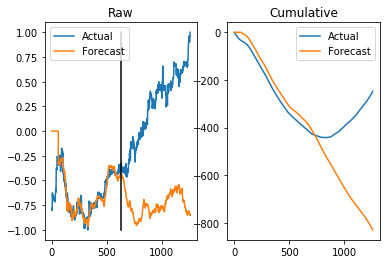

In [ ]:
#Could make predicted results a time series for nicer formating, and dates.
#Plot cumulative for cases when we've also differenced.
plot_pred(Xsub2,RNN_pred,50)

This RNN forecast is also WAY worse than a persistence forecast (tomorrow's price is the same as todays).
Big question: why is the price wandering away? Even if the model is fixed (weights unchanged), surely it should take the recent past (which the model uses to forecast tomorrow's demand) into account.

Note the effect of further smoothing, which suggests a clearer trend, that might be easier to model.
That suggests the convolutional networks may be useful,
perhaps with running averages to smooth the data.  Forecasting on a week timescale might allevative some of that too?

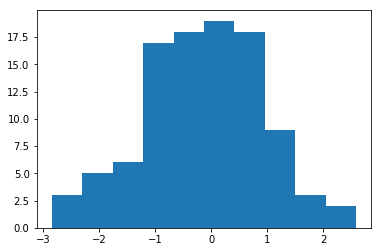

In [ ]:
#Let's look at the differences between the predicted and actual
#results at the end of the period.
pred_diff=RNN_pred[-1]-Xsub2[-1]
plt.hist(pred_diff)
plt.show()

In [ ]:
#Let's now see how much the predictions vary (across all stocks) at the end of training, 20 trading days after that,
# and at the end of the period, a year or two out.

#Note that these predictions use the data from those periods, but the model is not being updated.

def plot_err_hist(target,pred,Nc):
    '''plot_err_hist

    Makes histograms of the errors between the target and prediction
    at multiple time scales aroud the tend of the training period.
    '''
    
    Nc = int(len(Xsub2)/2)
    plt.figure(figsize=(10,6))

    plt.subplot(141)
    pred_diff=pred[Nc-20]-target[Nc-20]
    plt.title('End of training - 20 days')
    plt.hist(pred_diff)

    plt.subplot(142)
    pred_diff=pred[Nc]-target[Nc]
    plt.title('End of training')
    plt.hist(pred_diff)

    plt.subplot(143)
    pred_diff=pred[Nc+20]-target[Nc+20]
    plt.title('End of training+20 days')
    plt.hist(pred_diff)

    plt.subplot(144)
    pred_diff=pred[-1]-target[-1]
    plt.hist(pred_diff)
    plt.title('End of test')
    plt.xlabel('Forecast Residuals')
    plt.show()


The final graph is worst, it is also trying to predict many years ahead, based on essentially short-term info.
Probably could describe build up of cumulative errors as a random walk?
Would guess errors grows as sqrt(T), so the variance of this distribution grows as T.
